In [15]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `~/SSD/Code/Julia/tinympc-dev-julia/quadrotor_socp/Project.toml`


In [16]:
using LinearAlgebra
using PyPlot
using Printf
using Random

In [17]:
include("../LibTinyMPC.jl")

export_diag_to_c (generic function with 1 method)

In [18]:
#Rocket landing
NSTATES = 6
NINPUTS = 3
NHORIZON = 30
NTOTAL = 201

# Initialize cache, settings, bounds, socs, workspace, solver

###### Cache
rho = 1e2
Kinf = zeros(NINPUTS,NSTATES)
Pinf = zeros(NSTATES,NSTATES)
Quu_inv = zeros(NINPUTS,NINPUTS)
AmBKt = zeros(NSTATES,NSTATES)
APf = zeros(NSTATES)
BPf = zeros(NINPUTS)
my_cache = TinyCache(rho, Kinf, Pinf, Quu_inv, AmBKt, APf, BPf)
#####

##### Settings
abs_pri_tol = 1e-2
abs_dua_tol = 1e-2
max_iter = 100
check_termination = 1
en_state_bound = 0  # ENABLE CONSTRAINTS OR NOT
en_input_bound = 1
en_state_soc = 0
en_input_soc = 1
my_stgs = TinySettings(abs_pri_tol, abs_dua_tol, max_iter, check_termination, en_state_bound, en_input_bound, en_state_soc, en_input_soc)
#####

###### Bounds
# umin = -10.0*ones(NINPUTS, NHORIZON-1)
# umax = 105*ones(NINPUTS, NHORIZON-1)
umin = repeat([-10; -10; 0.0], 1, NHORIZON-1)*1
umax = repeat([10; 10; 15], 1, NHORIZON-1)*1
xmin = repeat([-4.5; -4.5; -0.5; -10; -10; -20], 1, NHORIZON)
xmax = repeat([4.5; 4.5; 100.0; 10; 10; 20], 1, NHORIZON)
z = zeros(NINPUTS, NHORIZON-1)
znew = zeros(NINPUTS, NHORIZON-1)
v = zeros(NSTATES, NHORIZON)
vnew = zeros(NSTATES, NHORIZON)
y = zeros(NINPUTS, NHORIZON-1)
g = zeros(NSTATES, NHORIZON)
my_bounds = TinyBounds(umin, umax, xmin, xmax, z, znew, v, vnew, y, g)
#####

##### SOCS
ncu = 1
ncx = 0
cu = [0.3, 0]  # 0.3 is the thrust coefficient
cx = [0.5, 0]
qcu = [3, 0]  # 3 is the dimensions of 1st cone
qux = [3, 0]
Acu = [1, 0]
Acx = [1, 0]
zc = [zeros(NINPUTS, NHORIZON-1), zeros(NINPUTS, NHORIZON-1)]
vc = [zeros(NSTATES, NHORIZON), zeros(NSTATES, NHORIZON)]
zcnew = [zeros(NINPUTS, NHORIZON-1), zeros(NINPUTS, NHORIZON-1)]
vcnew = [zeros(NSTATES, NHORIZON), zeros(NSTATES, NHORIZON)]
yc = [zeros(NINPUTS, NHORIZON-1), zeros(NINPUTS, NHORIZON-1)]
gc = [zeros(NSTATES, NHORIZON), zeros(NSTATES, NHORIZON)]
my_socs = TinySocs(ncu, ncx, cu, cx, qcu, qux, Acu, Acx, zc, zcnew, vc, vcnew, yc, gc)
#####

##### Workspace
x = zeros(NSTATES, NHORIZON)
u = zeros(NINPUTS, NHORIZON-1)
q = zeros(NSTATES, NHORIZON)
r = zeros(NINPUTS, NHORIZON-1)
p = zeros(NSTATES, NHORIZON)
d = zeros(NINPUTS, NHORIZON-1)
pri_res_state = 1.0
pri_res_input = 1.0
dua_res_state = 1.0
dua_res_input = 1.0
status = 0
iter = 0
Q = Diagonal([1e1, 1e1, 1e2, 1e1, 1e1, 1e2])*0
R = 1e2*I(NINPUTS)

# Actually double-integrator dynamics
h = 0.02 #20 Hz
gravity = 9.81
temp_n = Int(NSTATES/2)
Adyn = [I(temp_n) h*I(temp_n); zeros(temp_n,temp_n) I(temp_n)]
Bdyn = [0.5*h*h*I(temp_n); h*I(temp_n)];  # thrust vectors = 1/10 controls, making condition number nicer :) 
fdyn = [0.0, 0.0, -0.5*h*h*gravity, 0.0, 0.0, -h*gravity]
display(Adyn)
display(Bdyn)
display(fdyn)

t = h*(0:NTOTAL-1)
Xref = zeros(NSTATES, NTOTAL)
x0 = [0, 0, 0.0, 0, 0, 0.0]
xg = [5.0, 0.0, 0.0, 0.0, 0.0, 0.0]
# xg = x0*1
for k = 1:NTOTAL
  # Xref[1:3,k] = sin(1*t[k])*2*ones(temp_n)
  Xref[:,k] = (x0 + (k-1)*(xg-x0)/(NTOTAL-1))
  # Xref[:,k] .= xg
end
Xref = hcat([Xref repeat(xg, 1, NHORIZON)])
Uref = repeat([0; 0; gravity], 1, NTOTAL-1) 
Xref_hrz = 1*Xref[:,1:NHORIZON]
Uref_hrz = 1*Uref[:,1:NHORIZON-1]
# Could provide a better reference from other solvers

Qu = zeros(NINPUTS, NINPUTS)
my_work = TinyWorkspace(x, u, q, r, p, d, pri_res_state, pri_res_input, dua_res_state, dua_res_input, status, iter, Q, R, Adyn, Bdyn, fdyn, Xref_hrz, Uref_hrz, Qu, my_bounds, my_socs)
#####

# Solver
solver = TinySolver(my_stgs, my_cache, my_work)

6×6 SparseArrays.SparseMatrixCSC{Float64, Int64} with 9 stored entries:
 1.0   ⋅    ⋅   0.02   ⋅     ⋅ 
  ⋅   1.0   ⋅    ⋅    0.02   ⋅ 
  ⋅    ⋅   1.0   ⋅     ⋅    0.02
  ⋅    ⋅    ⋅   1.0    ⋅     ⋅ 
  ⋅    ⋅    ⋅    ⋅    1.0    ⋅ 
  ⋅    ⋅    ⋅    ⋅     ⋅    1.0

6×3 SparseArrays.SparseMatrixCSC{Float64, Int64} with 6 stored entries:
 0.0002   ⋅       ⋅ 
  ⋅      0.0002   ⋅ 
  ⋅       ⋅      0.0002
 0.02     ⋅       ⋅ 
  ⋅      0.02     ⋅ 
  ⋅       ⋅      0.02

6-element Vector{Float64}:
  0.0
  0.0
 -0.001962
  0.0
  0.0
 -0.1962

TinySolver(TinySettings(0.01, 0.01, 100, 1, 0, 1, 0, 1), TinyCache(100.0, [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0]), TinyWorkspace([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], 1.0, 1.0, 1.0, 1.0, 0, 0, [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [100.0 0.0 0.0; 0.0 100.0 0.0; 0.0 0.0 100.0], [1.0 0.0 … 0.0 0.0; 

In [19]:
compute_cache!(solver, Q, R)

6-element Vector{Float64}:
 -7129.195643567793
     0.0
     0.0
 -5126.635052999458
     0.0
     0.0

In [20]:
boilerplate = "#pragma once\n\n#include <tinympc/types.hpp>\n\n"

rho_string = "static const tinytype rho_value = " * string(solver.cache.rho) * ";\n\n"

A_data_string = export_mat_to_c("Adyn_data[NSTATES*NSTATES] ", solver.workspace.Adyn) * "\n\n"
B_data_string = export_mat_to_c("Bdyn_data[NSTATES*NINPUTS] ", solver.workspace.Bdyn) * "\n\n"
f_data_string = export_vec_to_c("fdyn_data[NSTATES] ", solver.workspace.fdyn) * "\n\n"

Kinf_data_string = export_mat_to_c("Kinf_data[NINPUTS*NSTATES] ", solver.cache.Kinf) * "\n\n"
Pinf_data_string = export_mat_to_c("Pinf_data[NSTATES*NSTATES] ", solver.cache.Pinf) * "\n\n"
Quu_inv_data_string = export_mat_to_c("Quu_inv_data[NINPUTS*NINPUTS] ", solver.cache.Quu_inv) * "\n\n"
AmBKt_data_string = export_mat_to_c("AmBKt_data[NSTATES*NSTATES] ", solver.cache.AmBKt) * "\n\n"
APf_data_string = export_vec_to_c("APf_data[NSTATES] ", solver.cache.APf) * "\n\n"
BPf_data_string = export_vec_to_c("BPf_data[NINPUTS] ", solver.cache.BPf) * "\n\n"

Q_data_string = export_diag_to_c("Q_data[NSTATES]", solver.workspace.Q) * "\n\n"
R_data_string = export_diag_to_c("R_data[NINPUTS]", solver.workspace.R) * "\n\n"

open("param_files/quadrotor_20hz_params.hpp", "w") do file
# open("/home/khai/SSD/Code/tinympc-crazyflie-firmware/examples/controller_tinympc_socp/src/quadrotor_20hz.hpp", "w") do file
    write(file, boilerplate);
    write(file, rho_string);
    write(file, A_data_string);
    write(file, B_data_string);
    write(file, f_data_string);
    write(file, Q_data_string);
    write(file, R_data_string);
    write(file, Kinf_data_string);
    write(file, Pinf_data_string);
    write(file, Quu_inv_data_string);
    write(file, AmBKt_data_string);
    write(file, APf_data_string);
    write(file, BPf_data_string);

end

81

In [21]:
# MPC loop
solver.settings.en_input_soc = 1
# solver.settings.en_state_bound = 0
# solver.settings.en_state_soc = 1

Random.seed!(1234)
Xhist = zeros(NSTATES, NTOTAL)
# x0 = [4, 2, 3, 1, -2, 2.0]
Xhist[:,1] .= x0*1.0 + randn(NSTATES)*0.0
display(Xhist[:,1])
Uhist = zeros(NINPUTS, NTOTAL-1)

alpha = 0.5

NRUNS = NTOTAL-1  
for i = 1:NRUNS
    # i%10 == 0 && print("i = ", i, "\n")
    # Get measurements
    pos_norm = norm(Xhist[1:3, i], Inf) / 1e2 # 1% noise
    vel_norm = norm(Xhist[4:6, i], Inf) / 1e4 # 1ppm noise
    noise_pos = randn(3)
    noise_vel = randn(3)
    solver.workspace.x[:,1] = Xhist[:,i] + 0*[noise_pos * pos_norm; noise_vel * vel_norm]
    # print("x = ", solver.workspace.x[:,1], "\n")

    # Reference
    solver.workspace.Xref = 1*Xref[:,i:i+NHORIZON-1]

    solve_admm!(solver)
    # Uhist[:,i] .= solver.workspace.u[:,1]
    # Uhist[:,i] .= solver.workspace.Uref[:,1]
    Uhist[:,i] .= [2.0; 0; gravity]

    # Simulate

    # Attitude inner loop -- first-order system
    # if i > 1
    #     Uhist[:,i] .= Uhist[:,i] * alpha + Uhist[:,i-1] * (1 - alpha)
    # end

    # Clamp control input
    # Uhist[:,i] = max.(min.(Uhist[:,i], umax[:,1]), umin[:,1])

    # print(Upred, "\n")
    # print(solver.workspace.u, "\n")
    # print(solver.workspace.x, "\n")
    
    Xhist[:,i+1] .= Adyn*Xhist[:,i] + Bdyn*Uhist[:,i] + fdyn
end

6-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

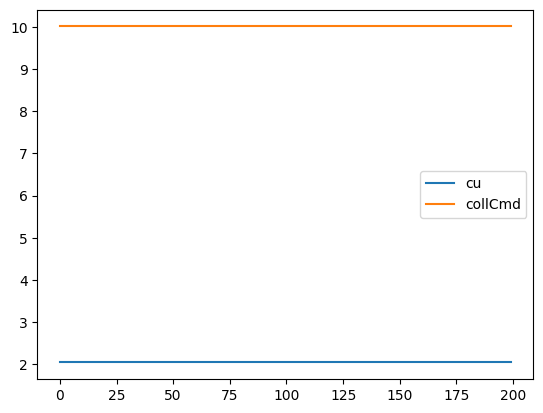

In [22]:
cu_hist = zeros(NRUNS)
collCmd = zeros(NRUNS)
for i = 1:NRUNS
    cu_hist[i] = 10*norm(Uhist[1:2,i])/Uhist[3,i]
    collCmd[i] = norm(Uhist[:,i])/1
end
fig = plt.figure()
plot(cu_hist, label="cu")
plot(collCmd, label="collCmd")
plt.legend()
fig

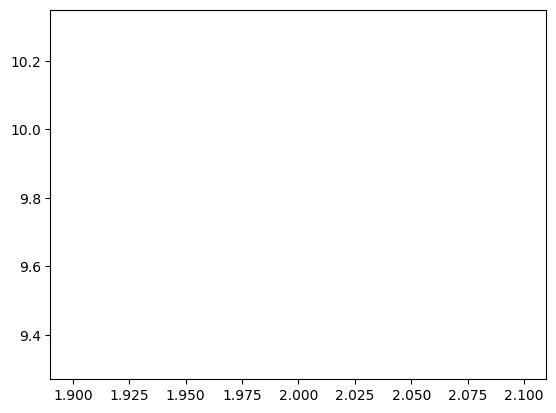

In [23]:
fig = plt.figure()
plot(Uhist[1, 1:NRUNS], Uhist[3, 1:NRUNS])
fig

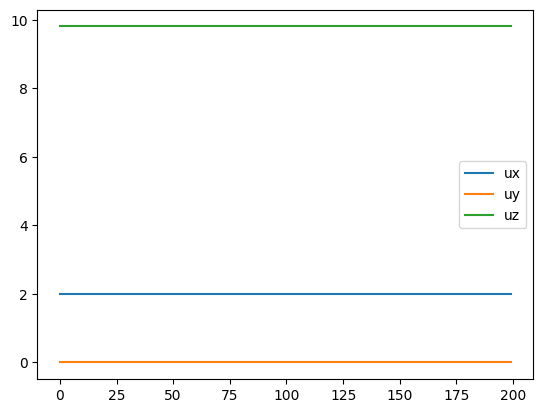

In [24]:
fig = plt.figure()
plot(Uhist[1, 1:NRUNS])
plot(Uhist[2, 1:NRUNS])
plot(Uhist[3, 1:NRUNS])
plt.legend(["ux", "uy", "uz"])
fig

In [25]:
vio_count = 0
for idx in 1:NRUNS
    (sqrt(Uhist[1,idx]^2 + Uhist[2,idx]^2) - cu[1]*Uhist[3,idx] >= 1e-2) && (vio_count += 1)  # test cone constraint
    # (sqrt(Xhist[1,idx]^2 + Xhist[2,idx]^2) - cx[1]*Xhist[3,idx] >= 1e-1) && (vio_count += 1)  # test cone constraint
end
print("vio_count = ", vio_count, "\n")
print("max control = ", maximum(Uhist[:, 1:NRUNS]), "\n")
print("min control = ", minimum(Uhist[:, 1:NRUNS]), "\n")
print("max state = ", maximum(Xhist[2,:]))

vio_count = 0
max control = 9.81
min control = 0.0
max state = 0.0

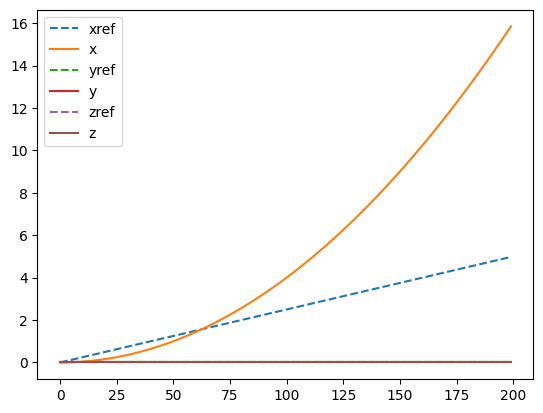

In [26]:
fig = plt.figure()
plot(Xref[1,1:NRUNS], "--")
plot(Xhist[1,1:NRUNS])
plot(Xref[2,1:NRUNS], "--") 
plot(Xhist[2,1:NRUNS])
plot(Xref[3,1:NRUNS], "--") 
plot(Xhist[3,1:NRUNS])
plt.legend(["xref", "x", "yref", "y", "zref", "z"])
# put limit on axis
# plt.ylim(-5, 20)
# plt.xlim(0, 300)
fig

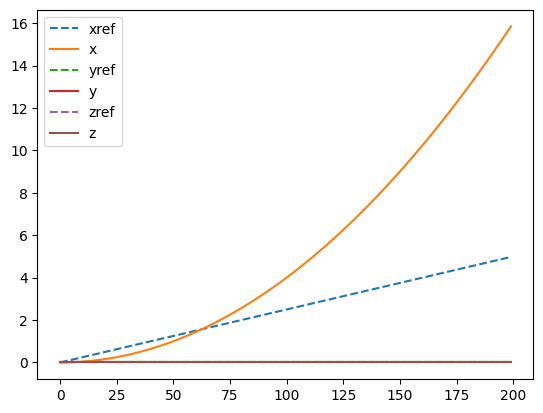

In [27]:
fig = plt.figure()
plot(Xref[1,1:NRUNS], "--")
plot(Xhist[1,1:NRUNS])
plot(Xref[2,1:NRUNS], "--") 
plot(Xhist[2,1:NRUNS])
plot(Xref[3,1:NRUNS], "--") 
plot(Xhist[3,1:NRUNS])
plt.legend(["xref", "x", "yref", "y", "zref", "z"])
# put limit on axis
# plt.ylim(-5, 20)
# plt.xlim(0, 300)
fig

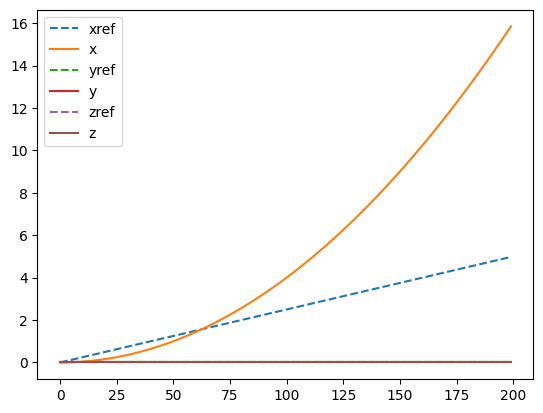

In [28]:
fig = plt.figure()
plot(Xref[1,1:NRUNS], "--")
plot(Xhist[1,1:NRUNS])
plot(Xref[2,1:NRUNS], "--") 
plot(Xhist[2,1:NRUNS])
plot(Xref[3,1:NRUNS], "--") 
plot(Xhist[3,1:NRUNS])
plt.legend(["xref", "x", "yref", "y", "zref", "z"])
# put limit on axis
# plt.ylim(-5, 20)
# plt.xlim(0, 300)
fig

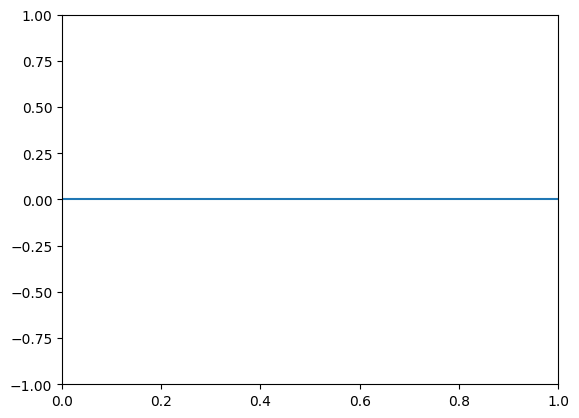

In [29]:
# # 3D
# fig = plt.figure()
# plot3D(Xhist[1,1:NTOTAL-1],Xhist[2,1:NTOTAL-1], Xhist[3,1:NTOTAL-1])
# fig
# # Xhist[:,NTOTAL-1]
fig = plt.figure()
plot(Xhist[1,1:NRUNS], Xhist[3,1:NRUNS])
plt.ylim(-1, 1.0)
plt.xlim(0, 1.0)
fig

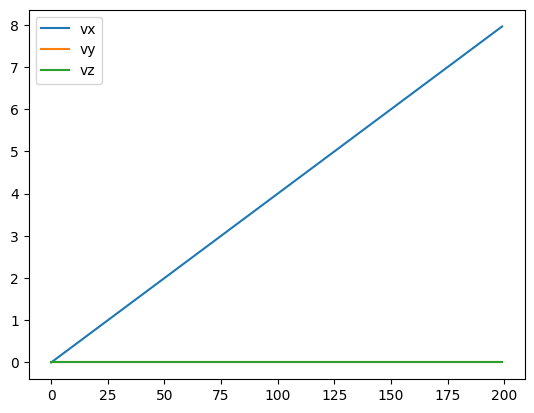

In [30]:
fig = plt.figure()
plot(Xhist[4,1:NRUNS])
plot(Xhist[5,1:NRUNS])
plot(Xhist[6,1:NRUNS])
plt.legend(["vx", "vy", "vz"])
# put limit on axis
# plt.ylim(-5, 20)
# plt.xlim(0, 300)
fig

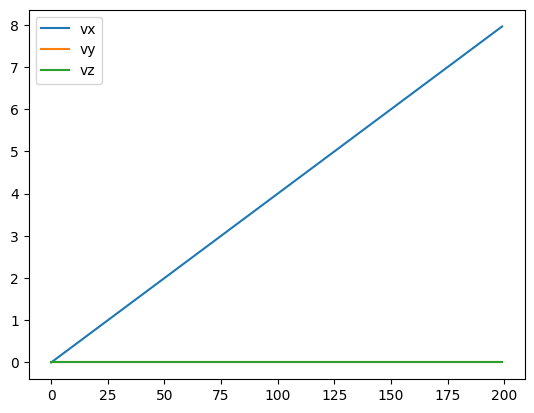

In [31]:
fig = plt.figure()
plot(Xhist[4,1:NRUNS])
plot(Xhist[5,1:NRUNS])
plot(Xhist[6,1:NRUNS])
plt.legend(["vx", "vy", "vz"])
# put limit on axis
# plt.ylim(-5, 20)
# plt.xlim(0, 300)
fig